In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# GPD tail distribution

$X\sim\text{GPD}(\xi, \sigma, \gamma)$ with pdf

$$
f(x) = \sigma^{-1}\left[1+\frac{ \xi(x-\gamma)}{\sigma}\right]^{-(\xi+1)/\xi},\text{ }x>\gamma
$$

In [11]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logps(self):
        if self.name == "GPD-Tail":
            def logp_body(X, parms,  γ):
                return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                ξ, σ  = parms
                if np.all(parms > 0):
                    return(- len(X)* np.log(σ) -(1 + ξ) / ξ * np.sum(np.log(1+ξ *(X - γ) / σ)))
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logds(self):
        if self.name == "GPD-Tail":
            
            def logd_body(x, parms,  γ):
                return(None)
            
            def logd_tail(x, parms,  γ):
                ξ, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(ξ))
                s = np.logical_and(np.logical_and(ξ > 0, σ), x > γ)
                res[np.where(s)] = - np.log(σ[s]) -(1 + ξ[s]) / ξ[s] * np.log(1+ξ[s] *(x - γ[s]) / σ[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
    
    def set_cdf(self):
        def cdf(parms, γ, x):
                ξ, σ  = parms
                return(1 - (1+ ξ*(x - γ) / σ )**(-1 / ξ) )
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "GPD-Tail":
            def pdf(parms, γ, x):
                ξ, σ  = parms
                return(1 / σ * (1+ ξ*(x - γ) / σ )**(-(1+ξ) / ξ) )
        self.pdf = nb.jit(nopython = True)(pdf)
                
        
    def set_ppf(self):
        if self.name == "GPD-Tail":
            def ppf(parms, γ, y):
                ξ, σ = parms
                return(γ + σ / ξ * ((1 - y)**(-ξ) - 1))
        self.ppf = ppf

In [13]:
gdp_tail_dist = loss_model("GPD-Tail", ["ξ", "σ"])
print(gdp_tail_dist.name, gdp_tail_dist.parm_names, gdp_tail_dist.d)
parms = np.array([2, 3])
ξ, σ = parms
x, y = 2, 0.5
γ = 1.5
gdp_tail_dist.set_cdf(), gdp_tail_dist.set_pdf(), gdp_tail_dist.set_ppf()
gdp_tail_dist.cdf(parms,γ, x) - st.genpareto(ξ).cdf((x-γ) / σ), gdp_tail_dist.ppf(parms, γ, y)-  (γ +  σ * st.genpareto(ξ).ppf(y)), gdp_tail_dist.pdf(parms,γ,  γ)-  st.genpareto(ξ).pdf((γ-γ) / σ) / σ 

GPD-Tail ['ξ', 'σ'] 2


(-2.7755575615628914e-17, 0.0, 0.0)

In [14]:
X = st.genpareto(ξ).rvs(size = 100) * σ + γ
gdp_tail_dist.set_logps()
print(gdp_tail_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.genpareto(ξ).pdf((X-γ) / σ) / σ )))

0.0


In [15]:
X = st.genpareto(ξ).rvs(size = 100) * σ + γ
ξ_prior, σ_prior, γ_prior= bsm.prior_model('gamma','ξ', 1, 1), bsm.prior_model('gamma','σ', 1, 1),  bsm.prior_model('gamma','γ', 1, 1)
prior_gamma_model = bsm.independent_priors([ξ_prior, σ_prior, γ_prior])
particle_cloud = prior_gamma_model.sample(20)
gdp_tail_dist.set_logds()
ξ_vec, σ_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1], particle_cloud.values[:,2]
print(gdp_tail_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) - 
      np.array([np.log(st.genpareto(ξ_vec[i]).pdf((X[0]-γ_vec[i]) / σ_vec[i]) / σ_vec[i]) for i in range(len(γ_vec)) ]) )

[-4.44089210e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00
 -4.44089210e-16  0.00000000e+00  0.00000000e+00  1.33226763e-15
 -4.44089210e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.66133815e-16 -8.88178420e-16  0.00000000e+00  4.44089210e-16
 -4.44089210e-16             nan  0.00000000e+00  4.44089210e-16]


C:\Users\pierr\AppData\Local\Temp/ipykernel_496/1651546845.py:8: RuntimeWarning: divide by zero encountered in log
  np.array([np.log(st.genpareto(ξ_vec[i]).pdf((X[0]-γ_vec[i]) / σ_vec[i]) / σ_vec[i]) for i in range(len(γ_vec)) ]) )
C:\Users\pierr\AppData\Local\Temp/ipykernel_496/1651546845.py:7: RuntimeWarning: invalid value encountered in subtract
  print(gdp_tail_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -


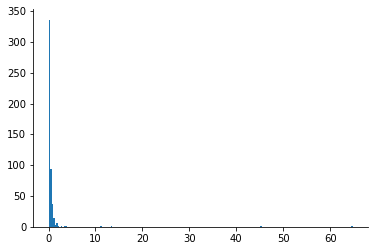

In [23]:
import bayessplicedmodels as bsm
parms_true = np.array([3, 1.6, 2, 2])
f1, f2 =  bsm.loss_model("Exp", ["k1"]), loss_model("GPD-Tail", ["ξ2", "σ2"])
f = bsm.spliced_loss_model(f1 , f2, "continuous") 
X= f.sample(parms_true, 500) 
plt.hist(X,bins=200)
sns.despine()


In [24]:
k1_prior, β1_prior = bsm.prior_model('gamma','k1', 1, 1), bsm.prior_model('fixed','β1', 1, 1)
ξ_prior, σ_prior= bsm.prior_model('gamma','ξ2', 1, 1), bsm.prior_model('gamma','σ2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('gamma','γ',1, 1), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([k1_prior,ξ_prior, σ_prior, γ_prior])

In [25]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.007521629333496094 ;ESS: 2000 ;steps:3 ;particle moved: 99.075%
Generation: 2 ;temperature: 0.027043081799547508 ;ESS: 1999 ;steps:3 ;particle moved: 98.225%
Generation: 3 ;temperature: 0.07600405215072192 ;ESS: 2000 ;steps:4 ;particle moved: 99.25%
Generation: 4 ;temperature: 0.1915776441127317 ;ESS: 2000 ;steps:4 ;particle moved: 99.0%
Generation: 5 ;temperature: 0.4307593059236523 ;ESS: 2000 ;steps:4 ;particle moved: 99.3%
Generation: 6 ;temperature: 0.9282563576892346 ;ESS: 1999 ;steps:4 ;particle moved: 99.775%
Generation: 7 ;temperature: 1.0 ;ESS: 3954 ;steps:3 ;particle moved: 98.9%
Wall time: 9.29 s


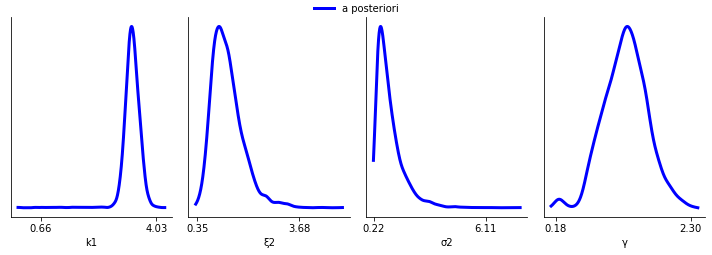

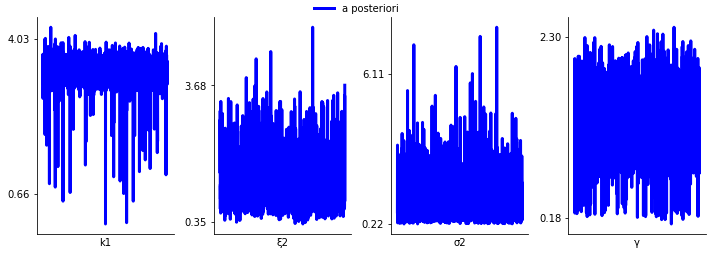

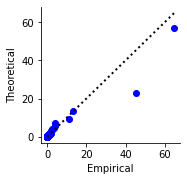

In [26]:
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

## On the danish fire insurance data

In [32]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal"]
body_model_param_names = [['λ1'], ["r1", "m1"], ["k1", "β1"], ["μ1", "λ1"], ["μ1", "σ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [[bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[1][1], 1, 1)], 
                [bsm.prior_model('gamma',body_model_param_names[2][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[2][1], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[3][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[3][1], 1, 1)],
                [bsm.prior_model('normal',body_model_param_names[4][0], 0, 0.5), bsm.prior_model('gamma',body_model_param_names[4][1], 1, 1)]
]

# Model for the tail of the distribution
tail_model_names = ["GPD-Tail"]
tail_model_param_names = [["ξ2", "σ2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [
                [bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[0][1], 1, 1)]]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))    
fs_dict = dict(zip(f_names, fs))

In [33]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):     
        trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
        return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))

Wall time: 1min 56s


In [34]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
3,Inverse-Gaussian-GPD-Tail-continuous,5,0.975286,-3848.139058,7576.119428,7592.104605,0.983312,433.928200
2,Weibull-GPD-Tail-continuous,5,0.931802,-3852.351478,7630.152254,7651.536978,0.014563,544.105799
1,Gamma-GPD-Tail-continuous,5,0.931853,-3854.280348,7629.861064,7652.449187,0.002116,544.305330
4,Lognormal-GPD-Tail-continuous,5,0.933598,-3859.813355,7645.752411,7669.409770,0.000008,545.734584
0,Exp-GPD-Tail-continuous,4,1.824609,-4657.753172,9268.749082,9281.804377,0.000000,849.362376


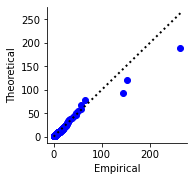

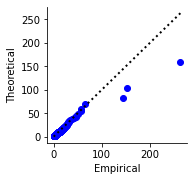

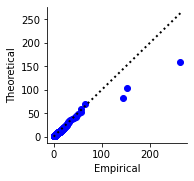

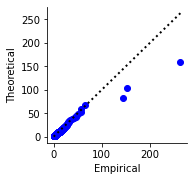

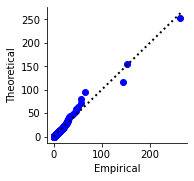

In [36]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    # bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
    bsm.qq_plot(X, f, trace.mean().values)